# FFT

the goal of this notebook is to find a mathmematical way to extract exercice series.

In [1]:
from pathlib import Path
import sys

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler

from scipy.signal import butter, filtfilt

%matplotlib inline

# Data cleaning and merging

This function as to goal to merge the 2 captors data into 1 pandas array

In [2]:
# List the recordings in folder
# each recording folder must be named with the first word as the label, followed by an underscore: 
# e.g. `punch_xxx` and in this folder, the csv file corresponding. 
def get_data(base_dir, files):
    # read the data
    recordings = {}

    files = Path('.').joinpath(base_dir).glob(files)

    for f in sorted(files):

        data_info = str(f).split('/')[-1].split('_')
        label = data_info[0]
        placement = data_info[-2]
        val_type  = data_info[-1].split('.')[0]

        if(val_type == 'acc' and placement == 'arm'):
            this_gesture = pd.read_csv(f, header=0, names=['Phone timestamp','sensor timestamp [ns]','X [mg]','Y [mg]','Z [mg]'], index_col=0, sep=';', parse_dates=True)
            this_gesture = this_gesture.drop('sensor timestamp [ns]',axis=1)
            this_gesture = this_gesture.rename(columns={'X [mg]': 'X_arm', 'Y [mg]': 'Y_arm', 'Z [mg]': 'Z_arm'})
            this_gesture = this_gesture.resample('100ms').mean()

            if label in recordings.keys():             # if the label already exists in the dictionary
                recordings[label].append(this_gesture) # append the new gesture to the list
            else:
                recordings[label] = [this_gesture]     # otherwise, create a list with one element

        elif(val_type == 'acc' and placement == 'feet'):

            this_gesture = pd.read_csv(f, header=0, names=['Phone timestamp','sensor timestamp [ns]','X [mg]','Y [mg]','Z [mg]'], index_col=0, sep=';', parse_dates=True)
            this_gesture = this_gesture.rename(columns={'X [mg]': 'X_feet', 'Y [mg]': 'Y_feet', 'Z [mg]': 'Z_feet'})
            this_gesture = this_gesture.drop('sensor timestamp [ns]',axis=1)
            this_gesture = this_gesture.resample('100ms').mean()

            recordings[label][-1] = recordings[label][-1].join(this_gesture, how='inner', lsuffix='left', rsuffix='right')



    labels = recordings.keys()
    print(f'{len(labels)} labels found ({labels}).')

    return recordings


In [4]:
recordings = get_data('Data','**/*.txt')

4 labels found (dict_keys(['Dead', 'Ohp', 'Pullup', 'Squat'])).


# Simple series separator

this was an experiment base on the presemption that before a exercice serie there was a moment of immobility. To verify this we need first to prepare the data. Here we show the different steps we take to prepare the data:
scale, abs, get the maximum.

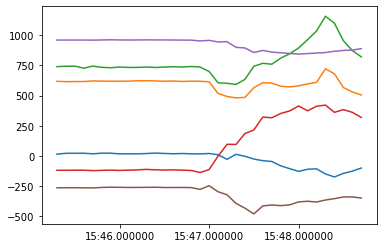

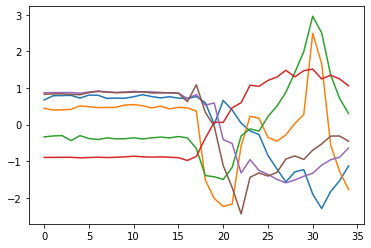

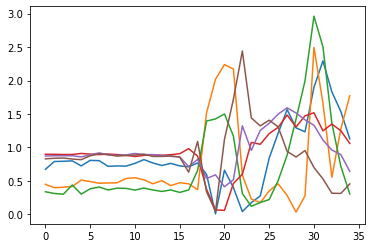

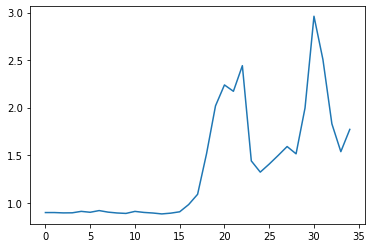

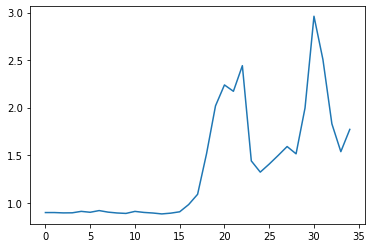

In [5]:
test_record = recordings['Squat'][0]

plt.plot(test_record)
plt.show()

scaler = StandardScaler()
test_record_show = scaler.fit_transform(test_record)
plt.plot(test_record_show)
plt.show()

scaler = StandardScaler()
test_record_show = scaler.fit_transform(test_record)
test_record_show = np.absolute(test_record_show)
plt.plot(test_record_show)
plt.show()

scaler = StandardScaler()
test_record_show = scaler.fit_transform(test_record)
test_record_show = np.absolute(test_record_show)
test_record_show = np.max(test_record_show,axis=1)
plt.plot(test_record_show)
plt.show()

scaler = StandardScaler()
test_record_show = scaler.fit_transform(test_record)
test_record_show = np.absolute(test_record_show)
test_record_show = np.max(test_record_show,axis=1)


plt.plot(test_record_show)
plt.show()

In [6]:
def isol_min(data, threshold):
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    data = np.absolute(data)
    data = np.max(data,axis=1)
    return data > 1.

We can see if we put a threshold we can isolate the movement 

(35, 6)
(35,)


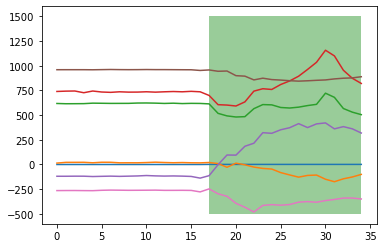

In [7]:
isol = isol_min(test_record,0.0)
print(test_record.shape)
print(isol.shape)
index = np.arange(0,isol.shape[0])
plt.plot(index,isol)
plt.fill_between(index, -500,1500, where=isol==True, facecolor='green', alpha=0.4, label='upstairs')
plt.plot(index,test_record)


but this solution is not performant on other movement so we have forget about using it.

(29, 6)
(29,)


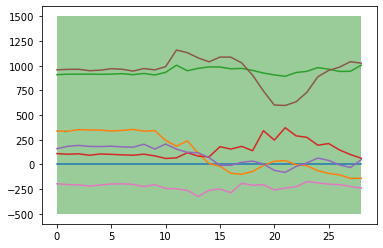

In [8]:
test_record = recordings['Pullup'][0]

isol = isol_min(test_record,0.0)
print(test_record.shape)
print(isol.shape)
index = np.arange(0,isol.shape[0])
plt.plot(index,isol)
plt.fill_between(index, -500,1500, where=isol==True, facecolor='green', alpha=0.4, label='upstairs')
plt.plot(index,test_record)

# FFT

in this experiment we try to see if we can see a spike in the fft of a serie of exercice

In [3]:
sampling_rate = 10
sample_spacing = 0.1

In [4]:
recordings = get_data('Data_old','**/*.txt')

5 labels found (dict_keys(['benchAlt', 'dead', 'ohp', 'squat', 'traction'])).


(221,)


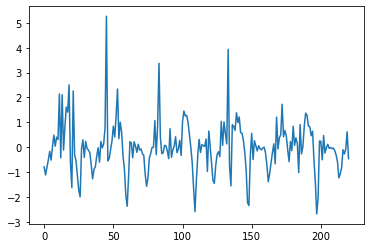

In [5]:
from numpy import linalg as LA
test_serie = recordings['dead'][0]
test_serie_plot = test_serie
scaler = StandardScaler()

test_serie = LA.norm(test_serie,  axis=1)
test_serie = np.array(test_serie)

test_serie = test_serie.reshape(-1, 1)
test_serie = scaler.fit_transform(test_serie)
test_serie = test_serie.flatten()
print(test_serie.shape)
plt.plot(test_serie)


# Result

below we see that indeed there is a spike at low frequency.

[ 0.          0.04524887  0.09049774  0.13574661  0.18099548  0.22624434
  0.27149321  0.31674208  0.36199095  0.40723982  0.45248869  0.49773756
  0.54298643  0.58823529  0.63348416  0.67873303  0.7239819   0.76923077
  0.81447964  0.85972851  0.90497738  0.95022624  0.99547511  1.04072398
  1.08597285  1.13122172  1.17647059  1.22171946  1.26696833  1.31221719
  1.35746606  1.40271493  1.4479638   1.49321267  1.53846154  1.58371041
  1.62895928  1.67420814  1.71945701  1.76470588  1.80995475  1.85520362
  1.90045249  1.94570136  1.99095023  2.0361991   2.08144796  2.12669683
  2.1719457   2.21719457  2.26244344  2.30769231  2.35294118  2.39819005
  2.44343891  2.48868778  2.53393665  2.57918552  2.62443439  2.66968326
  2.71493213  2.760181    2.80542986  2.85067873  2.8959276   2.94117647
  2.98642534  3.03167421  3.07692308  3.12217195  3.16742081  3.21266968
  3.25791855  3.30316742  3.34841629  3.39366516  3.43891403  3.4841629
  3.52941176  3.57466063  3.6199095   3.66515837  3.

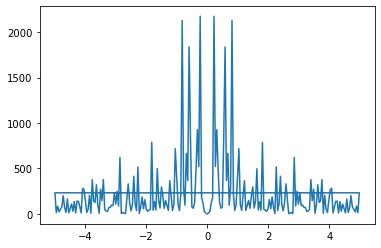

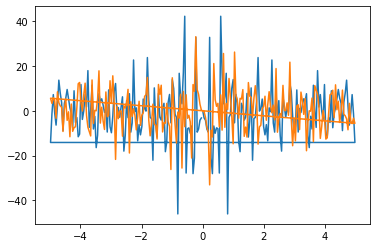

0.22624434389140272


In [6]:
sp = np.fft.fft(test_serie)
freq = np.fft.fftfreq(test_serie.shape[0], sample_spacing)

active_freq = np.abs(sp.real**2 + sp.imag**2)

plt.plot(freq, active_freq)
plt.show()
plt.plot(freq, sp.real, freq, sp.imag)
plt.show()

max_index = np.argmax(active_freq)
max_freq = freq[max_index]
print(max_freq)

# Period of one movement

we can plot the period of one movement because we know the frequency and endeed it prove that we can correctly extract series.

44.2


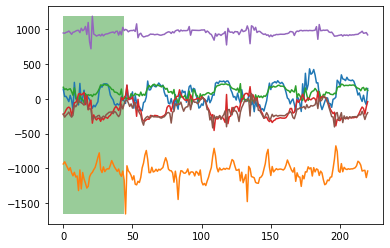

In [14]:
period = 1 / max_freq * sampling_rate
print(period)

index = np.arange(0,test_serie_plot.shape[0])
thresh = index < period

min_val = np.min(np.array(test_serie_plot).flatten())
max_val = np.max(np.array(test_serie_plot).flatten())

plt.fill_between(index, min_val, max_val, where=thresh==True, facecolor='green', alpha=0.4, label='upstairs')
plt.plot(index,test_serie_plot)

# Serie isolation

here we go further and try to apply the fft with a rolling window on the serie

In [15]:
serie_record = get_data('Data_serie_test','**/*.txt')
print(serie_record)
serie_record = serie_record['Test'][0]


1 labels found (dict_keys(['Test'])).
{'Test': [                          X_arm   Y_arm   Z_arm  X_feet  Y_feet  Z_feet
Phone timestamp                                                        
2021-12-29 11:02:38.600  976.75 -123.25  151.75    -3.8   990.8   -80.6
2021-12-29 11:02:38.700  929.60 -134.20  155.00   -13.0   981.4  -134.6
2021-12-29 11:02:38.800  973.80 -230.00  129.80   126.6   989.0  -255.0
2021-12-29 11:02:38.900  955.00 -262.00  128.80    80.6   873.0  -418.6
2021-12-29 11:02:39.000  943.60 -257.40  106.20  -528.2   922.8   -97.8
...                         ...     ...     ...     ...     ...     ...
2021-12-29 11:06:22.600  950.40 -178.20  234.20    76.8   974.4  -148.4
2021-12-29 11:06:22.700  947.00 -174.40  234.80    93.4   974.8  -119.2
2021-12-29 11:06:22.800  946.00 -177.80  240.40   117.8   976.8  -120.0
2021-12-29 11:06:22.900  948.20 -183.80  224.60   107.6   976.6  -108.4
2021-12-29 11:06:23.000  947.00 -189.00  218.00   117.2   977.0  -112.0

[2245 rows x 6 

This is the test serie we use in your project. it comport 3 series of exercies (2 bench, 1 Squat)

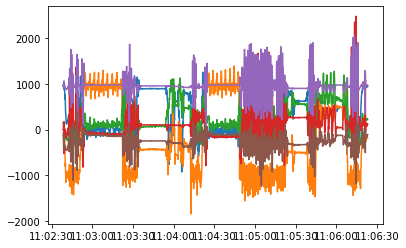

In [17]:
plt.plot(serie_record)


In [10]:
def best_variance(data):
    variance = np.var(data, axis=0)
    return data[:,np.argmax(variance)]

In [52]:
# this function is used to compact the data on one feature
def prepare_data(data, scaler):
    data_prepared = LA.norm(data,  axis=1)
    data_prepared = data_prepared.reshape(-1, 1)
    data_prepared = scaler.fit_transform(data_prepared)
    data_prepared = data_prepared.flatten()
    return data_prepared

Sample of the processed data

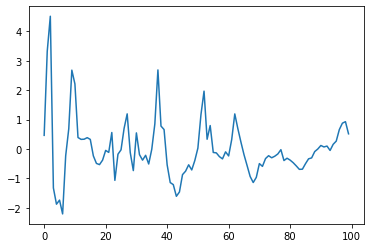

In [51]:
scaler = StandardScaler()

a = np.array(serie_record)

serie_record_shaped = prepare_data(a[100:200],scaler)

plt.plot(serie_record_shaped)

this part of the code allow us to test different part of the serie and analyse their fft

2
0.30000000000000004


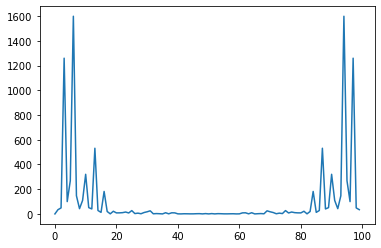

In [534]:
sp = np.fft.fft(serie_record_shaped)
active_freq = np.abs(sp.real**2 + sp.imag**2)
freq = np.fft.fftfreq(serie_record_shaped.shape[0], sample_spacing)
max_index = np.argmax(active_freq[1:5])
print(max_index)
max_freq = freq[1+max_index]
print(max_freq)
plt.plot(active_freq)

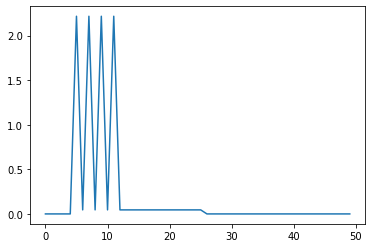

In [18]:
i = 0
window = 50
max_freq_over_time = []

while i + window < serie_record_shaped.size:
    
    sp = np.fft.fft(serie_record_shaped[i:window+i])
    i += 1
    active_freq = np.abs(sp.real**2 + sp.imag**2)
    max_index = np.argmax(active_freq)
    max_freq = freq[max_index]

    max_freq_over_time.append(max_freq)
    
plt.plot(max_freq_over_time)

# scan_fft

this function allow use to do the rolling fft over the entire serie

In [1]:
# we need at least 50 sample to get the low frequency representing our serie

#data := is the serie to be analysed
#padding := is the nombre of sample the window will move forward
#window := is the size of the window
#threshold := the threshold at which the spike in the fft is considered significant
#freq_by_rep := an array containing one or many desired range of frequency to analyse
def scan_ftt(data, padding=1, window=100, threshold=400,freq_by_rep=[[0,5]]):
    
    scaler = StandardScaler() # create the scaler to prepare the data
    result = np.zeros(data.shape[0]) # create an array of result
    
    i = 0
    
    freq = np.fft.fftfreq(window, sample_spacing) # get all the frequency that our fft can find
    
    # rolling on the dataset
    while i + window < data.shape[0]:
        
        # need to be done on the window and not the whole dataset
        split = data[i:window+i]
        split = prepare_data(split, scaler)
        
        # fft is done
        sp = np.fft.fft(split)
        # create a real value using the img and real of the fft
        active_freq = np.abs(sp.real**2 + sp.imag**2)
        # get the max response inpulse 

        for index, range_freq in enumerate(freq_by_rep):
            min_freq = range_freq[0]
            max_freq = range_freq[1]
        
            max_amplitude = np.max(active_freq[min_freq:max_freq])
            # get the max frequency that give the max response inpulse
            max_index = np.argmax(active_freq[min_freq:max_freq])
            max_freq = freq[min_freq+max_index]
            
            # get the period
            #period = int(1 / max_freq * sampling_rate)

            if max_amplitude > threshold:
                result[i:window+i] = index + 1
    
        i+= padding
        
    return result

# Result

we can see that the fft can split our serie into set of exercice serie and without any machine learing tool

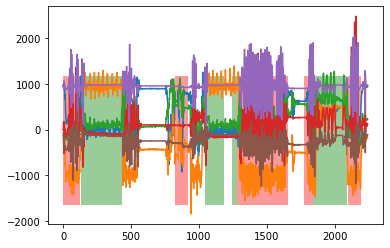

In [61]:

serie_record_np = np.array(serie_record)

freq_by_rep=[[0,5],[10,20]]

result = scan_ftt(serie_record_np, window=80, threshold=600, padding=1, freq_by_rep=freq_by_rep)

index = np.arange(0,serie_record.shape[0])

plt.fill_between(index, min_val, max_val, where=result==1, facecolor='green', alpha=0.4, label='upstairs')
plt.fill_between(index, min_val, max_val, where=result==2, facecolor='red', alpha=0.4, label='upstairs')
plt.plot(index,serie_record)

[False False False ...  True  True  True]


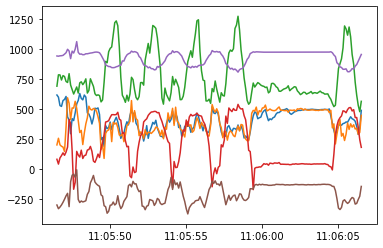

In [489]:
print(result==0)
splits = []
for x in np.split(serie_record, np.where(result!=1)[0]):
    if x.shape[0] > 1:
        splits.append(x)
plt.plot(splits[2])
